In [2]:
#loading libraries
import numpy as np
import scipy as sp
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import bokeh.plotting

# For interfacing with the file system
import glob
import subprocess
import os
import time

import importlib
import bilge_pype as bpy

# pipes bokeh output to the notebook
bokeh.io.output_notebook()
# enables some logging output
bpy.init_log(level='INFO')

Loading BokehJS ...

In [103]:
def compute_pw(df):
    # note that -D in config remove entries for diagonal alignments. You will need to add this back for similarity measures
    files = bpy.get_pairwise_distance(df, block=4000, output_folder='./pw_data', config='-k15 -w10 -p 0.9 -D', symmetric=True, cleanup=True)
    df_pw = pd.concat([pd.read_csv(f) for f in files]) # concatenate the csv files
    subprocess.run('rm -r ./pw_data', shell=True) # remove the output folder
    return bpy.get_best(df_pw,['query_id','database_id'],metric='AS', stat='idxmax')  # get the best alignment

# load data and concatenate dataframes
df_prf = pd.read_csv('pseudo_ref.csv.gz')
df_cl = pd.read_csv('pseudo_clst.csv.gz')
df_ref = bpy.read_fasta('ref_db.fa')
df = pd.concat([df_prf, df_cl, df_ref])
df_pw = compute_pw(df[['id','sequence']])
df_pw.to_csv('pseudo_pw.csv.gz', index=False, compression='infer') # save the data

pid[3154576] 2020-05-04 11:38:33.111 INFO: Making directory ./pw_data/
pid[3154576] 2020-05-04 11:38:33.123 INFO: processing block 0,0 0/3.0
pid[3154576] 2020-05-04 11:38:33.124 INFO: Making directory ./pw_aligner/
pid[3154576] 2020-05-04 11:38:35.244 INFO: processing block 0,1 1/3.0
pid[3154576] 2020-05-04 11:38:37.228 INFO: processing block 1,1 2/3.0


In [104]:
def get_cluster(dist, metric='precomputed', alt=True, min_samples=None):
    # runs tsne on distance matrix
    tsne = bpy.run_TSNE(dist, metric=metric)
    # run hdbscan on tsne output
    hdb = bpy.cluster_HDBSCAN(tsne, metric='euclidean', min_samples=20, min_cluster_size=10)
    hdb = hdb.rename(columns={'cluster_id':'hdbscan_id','ordering':'hdbscan_order'})
    # merge the data
    optics = bpy.cluster_OPTICS(dist, metric='precomputed', alt_label=alt, min_samples=min_samples)
    optics = optics.rename(columns={'cluster_id':'optics_id','ordering':'optics_order'})
    tsne = tsne.merge(optics, on='id', how='left')
    return tsne.merge(hdb, on='id', how='left')

def get_dist_matrix(df):
    # extract the pairwise distance matrix and use match_score as the metric
    m = bpy.get_feature_vector(df[['query_id','database_id','match_score']], symmetric=True)
    # make this matrix symmetric
    m = bpy.get_symmetric_matrix(m, sym_larger=False)
    # invert similarity to distance
    for i in range(0,len(m)):
        m.iloc[:,i] = 1-m.iloc[:,i]
        m.iat[i,i] = 0 # set diagonal values to zero
    return m

# load pairwise data
df = pd.read_csv('pseudo_pw.csv.gz')
# get the distance matrix
m = get_dist_matrix(df)
# perform tsne, hdscan, and optics on the data
tsne = get_cluster(m, metric='precomputed', min_samples=20)
tsne.to_csv('pseudo_tsne.csv.gz', compression='infer', index=False)

pid[3154576] 2020-05-04 11:38:45.969 INFO: running sklearn tsne with n_comp = 2
pid[3154576] 2020-05-04 11:39:02.848 INFO: Running HDBSCAN
pid[3154576] 2020-05-04 11:39:02.971 INFO: getting and ordering the results
pid[3154576] 2020-05-04 11:39:02.992 INFO: number of clusters = 21
pid[3154576] 2020-05-04 11:39:02.992 INFO: unclustered = 1128
pid[3154576] 2020-05-04 11:39:02.998 INFO: Running OPTICS
pid[3154576] 2020-05-04 11:39:03.120 INFO: max_eps = 0.5
pid[3154576] 2020-05-04 11:39:03.121 INFO: clust_OPTICS: iter=0 using min_samples=20
pid[3154576] 2020-05-04 11:39:06.319 INFO: clust_OPTICS: clusters=29 outliers=1286 delta=10.0
pid[3154576] 2020-05-04 11:39:06.320 INFO: using alt labeling
pid[3154576] 2020-05-04 11:39:07.431 INFO: n_clusters=29.0 n_unclustered=1335 N=5866


In [105]:
# load sequence data
prf = pd.read_csv('pseudo_ref.csv.gz')
prf['source'] = 'samples'
ref = bpy.read_fasta('ref_db.fa')
ref = ref[[('HAP' in i) for i in ref['id']]]
ref['source'] = 'reference'
ref['ref_id'] = ref['id']
clst = pd.read_csv('pseudo_clst.csv.gz')
clst['source'] = 'clst'
clst['clst_id'] = clst['id']
# align reference database to pseudo reference and pseudo reference clusters to pseudo reference
A = bpy.run_minimap2(prf, ref, config='-k8 -w1', cleanup=True).rename(columns={'query_id':'id'})
A = bpy.get_best(A,['id'],metric='match_score',stat='idxmax')
B = bpy.run_minimap2(prf, clst, config='-k8 -w1', cleanup=True).rename(columns={'query_id':'id'})
B = bpy.get_best(B,['id'],metric='match_score',stat='idxmax')
A = A.rename(columns={'database_id':'ref_id','match_score':'ref_match'})
B = B.rename(columns={'database_id':'clst_id','match_score':'clst_match'})
# merge alignment data
prf = prf.merge(A[['id','ref_id','ref_match']], on='id', how='left')
prf = prf.merge(B[['id','clst_id','clst_match']], on='id', how='left')
df = pd.concat([prf,ref,clst])
# merge into tsne
tsne = pd.read_csv('pseudo_tsne.csv.gz')
tsne = tsne.merge(df, on='id', how='left')
# add colors to ref_id
col = 'ref_id'
rid = np.unique(tsne[col].dropna())
cmap = bokeh.palettes.Category20b_20
colors = [cmap[i%len(cmap)] for i in range(0,len(rid))]
colors = pd.DataFrame(np.transpose([rid,colors]), columns=[col,'ref_id_color'])
tsne = tsne.merge(colors,on='ref_id',how='left')
# add colors to clst_id
col = 'clst_id'
rid = np.unique(tsne[col].dropna())
colors = [cmap[i%len(cmap)] for i in range(0,len(rid))]
colors = pd.DataFrame(np.transpose([rid,colors]), columns=[col,'clst_id_color'])
tsne = tsne.merge(colors,on='clst_id',how='left')

pid[3154576] 2020-05-04 11:39:07.646 INFO: Making directory ./minimap2/
pid[3154576] 2020-05-04 11:39:10.361 INFO: Making directory ./minimap2/


In [106]:
TOOLTIPS = [('id','@id'),
            ('ref_id', '@ref_id'),
            ('ref_match','@ref_match'),
            ('clst_id','@clst_id'),
            ('clst_match','@clst_match'),
            ('hdbscan_id','@hdbscan_id'),
            ('optics_id','@optics_id')]
p = bokeh.plotting.figure(plot_width=600, plot_height=500, tooltips=TOOLTIPS)

# plot samples colored by ref_match
d = tsne[tsne['source']=='samples']
mapper = bokeh.transform.linear_cmap(field_name='ref_match', palette=bokeh.palettes.Spectral11, low=0.8, high=1)
color_bar = bokeh.models.ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0))
#p.circle('f_0', 'f_1', color=mapper, size=5, source=d)
p.circle('f_0', 'f_1', color='clst_id_color', size=5, source=d)

# plot cluster centers
d = tsne[tsne['source']=='clst']
p.square('f_0', 'f_1', line_color='black', fill_color='red', size=6, source=d)
d = tsne[tsne['source']=='reference']
p.diamond('f_0', 'f_1', line_color='black', fill_color='blue', size=10, source=d)

p.add_layout(color_bar, 'right')
bokeh.plotting.show(p)

In [108]:
# Testing if split is a problem
cl = ['cluster27','cluster7']
#cl = df_clst[df_clst['cluster_id']==2]['id']
print(cl)
rid = []
for i in cl:
    rid+= [r for r in tsne[tsne['clst_id']==i]['id']] 
    
df = pd.read_csv('pseudo_ref.csv.gz')
df = df[df['id'].isin(rid)]
pw = compute_pw(df)
m = get_dist_matrix(pw)
out = get_cluster(m, metric='precomputed', alt=True, min_samples=None)

['cluster27', 'cluster7']
pid[3154576] 2020-05-04 11:41:32.258 INFO: Making directory ./pw_data/
pid[3154576] 2020-05-04 11:41:32.269 INFO: processing block 0,0 0/1.0
pid[3154576] 2020-05-04 11:41:32.269 INFO: Making directory ./pw_aligner/
pid[3154576] 2020-05-04 11:41:32.353 INFO: running sklearn tsne with n_comp = 2
pid[3154576] 2020-05-04 11:41:32.434 INFO: Running HDBSCAN
pid[3154576] 2020-05-04 11:41:32.438 INFO: getting and ordering the results
pid[3154576] 2020-05-04 11:41:32.438 INFO: number of clusters = 0
pid[3154576] 2020-05-04 11:41:32.439 INFO: unclustered = 7
pid[3154576] 2020-05-04 11:41:32.444 INFO: Running OPTICS
pid[3154576] 2020-05-04 11:41:32.445 INFO: max_eps = 0.5
pid[3154576] 2020-05-04 11:41:32.447 INFO: clust_OPTICS: iter=0 using min_samples=4
pid[3154576] 2020-05-04 11:41:32.449 INFO: clust_OPTICS: clusters=1 outliers=1 delta=2.0
pid[3154576] 2020-05-04 11:41:32.451 INFO: using alt labeling
pid[3154576] 2020-05-04 11:41:32.454 INFO: n_clusters=1.0 n_uncluster

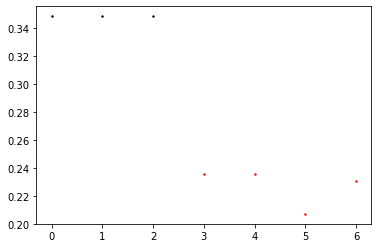

In [109]:
color = [[-1,'black'],
        [0,'red'],
        [1,'blue'],
        [2,'green'],
        [3,'purple'],
        [4,'orange'],
        [5,'cyan'],
        [6,'gray'],
        [9,'teal']]

for c in color:
    v = out['optics_id']==c[0]
    plt.scatter(out[v]['optics_order'], out[v]['reachability'], color=c[1], s=2)

In [110]:
p = bokeh.plotting.figure(plot_width=600, plot_height=500, tooltips=TOOLTIPS)

c2 = tsne['clst_id'].isin(cl)
for c in color:
    v = out['optics_id']==c[0]
    v = tsne['id'].isin(out[v]['id'])
    p.circle('f_0', 'f_1', color=c[1], size=5, source=tsne[v])

# plot cluster centers
d = tsne[(tsne['source']=='clst')&c2]
p.square('f_0', 'f_1', line_color='black', fill_color='red', size=5, source=d)
d = tsne[(tsne['source']=='reference')&c2]
p.diamond('f_0', 'f_1', line_color='black', fill_color='blue', size=10, source=d)

bokeh.plotting.show(p)

In [107]:
import pipeline_dev as pdev
importlib.reload(pdev)
import bilge_pype_dev as bpy
importlib.reload(bpy)

df = pd.read_csv('pseudo_ref.csv.gz')
cl = pd.read_csv('pseudo_clst.csv.gz')
df_align = bpy.run_minimap2(df, cl, cleanup=True)

vec = bpy.get_feature_vector(df_align[['query_id','database_id','AS']])
cols = vec.columns[vec.columns!='id']
x = vec[cols].values
cosim = bpy.dist_cosine(x.T, x.T)
cosim = pd.DataFrame(cosim, columns=cols)
cosim['id'] = cols
th_m=0.9
df_clst = bpy.cluster_hierarchical(cosim, metric='precomputed', linkage='complete', thresh=th_m)
df_clst[df_clst['cluster_id']>-1].sort_values(by=['cluster_id','id'])

pid[3154576] 2020-05-04 11:41:13.160 INFO: Making directory ./minimap2/
pid[3154576] 2020-05-04 11:41:13.778 INFO: Running hierarchical clustering


id cluster_id
20  cluster27          0
41   cluster7          0
33  cluster39          1
35  cluster40          1
37  cluster42          3
38  cluster43          3

pid[3154576] 2020-05-04 11:36:49.413 INFO: Running kmeans with n_clusters = 4
pid[3154576] 2020-05-04 11:36:49.459 INFO: Getting results


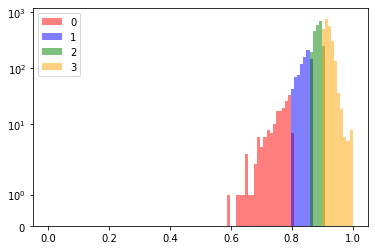

In [102]:
import sklearn

cid = ['cluster62','cluster63']
rid = tsne[tsne['clst_id'].isin(cid)]['id']
c = df_align['query_id'].isin(rid)
c2 = df_align['database_id'].isin(cid)
df_a = df_align
df_a = bpy.get_best(df_a,['query_id'],metric='AS',stat='idxmax')

metric = 'match_score'
df_a = df_a.rename(columns={'query_id':'id'})
y = bpy.cluster_Kmeans(df_a[['id',metric]], n_clusters=4, ordered=True)

color = ['red','blue','green','orange','teal']
for i in np.unique(y['cluster_id']):
    c = df_a['id'].isin(y[y['cluster_id']==i]['id'])
    plt.hist(df_a[c][metric], label=str(i), bins=np.linspace(0,1,100), alpha=0.5, color=color[i])
plt.legend()
plt.yscale('symlog')
plt.show()